In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [61]:
class Filters:
    # Sharpen, Blur, Canny
    def __init__(self, imagePath, kernel, low_threshold, high_threshold):
        self.image = cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB)
        self.kernel = kernel
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def convolution_rgb_image(self, image, kernel):
        # Checking for grayscale image
        kernel_height, kernel_width = kernel.shape
        if len(image.shape) == 2:
            image_height, image_width = image.shape
            output_matrix = np.zeros((image_height - kernel_height + 1, image_width - kernel_width + 1))
        else:
            image_height, image_width, image_depth = image.shape
            output_matrix = np.zeros((image_height - kernel_height + 1, image_width - kernel_width + 1, image_depth))

        if len(image.shape) == 2:
            for y in range(image_height - kernel_height + 1):
                for x in range(image_width - kernel_width + 1):
                    output_matrix[y, x] = np.sum(kernel * image[y : y + kernel_height, x : x + kernel_width])
        else:
            for d in range(image_depth):
                for y in range(image_height - kernel_height + 1):
                    for x in range(image_width - kernel_width + 1):
                        output_matrix[y, x, d] = np.sum(kernel * image[y : y + kernel_height, x : x + kernel_width, d])

        return output_matrix

    # Convolve the image with the Gaussian kernel
    def blur(self, image, kernel):
        """
        Convolve the image with the given kernel.
        """
        return np.abs(cv2.filter2D(image, -1, kernel))

    # Get the gradient magnitude and direction
    def gradient_magnitude_direction(self, image):
        """
        Calculate the gradient magnitude and direction.
        """
        # Calculate the intensity gradients
        gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        magnitude = np.sqrt(gx**2 + gy**2)
        direction = np.arctan2(gy, gx) * 180 / np.pi
        return magnitude, direction

    # Non-maximum suppression
    def non_max_suppression(self, image, direction):
        """
        Perform non-maximum suppression on the image.
        """
        M, N = image.shape
        Z = np.zeros((M, N), dtype=np.int32)

        angle = direction * np.pi / 180
        angle[angle < 0] += np.pi

        for i in range(1, M - 1):
            for j in range(1, N - 1):
                try:
                    q = 255
                    r = 255

                    # angle 0
                    if (0 <= angle[i, j] < np.pi / 8) or (7 * np.pi / 8 <= angle[i, j] <= np.pi):
                        q = image[i, j + 1]
                        r = image[i, j - 1]
                    # angle 45
                    elif np.pi / 8 <= angle[i, j] < 3 * np.pi / 8:
                        q = image[i + 1, j - 1]
                        r = image[i - 1, j + 1]
                    # angle 90
                    elif 3 * np.pi / 8 <= angle[i, j] < 5 * np.pi / 8:
                        q = image[i + 1, j]
                        r = image[i - 1, j]
                    # angle 135
                    elif 5 * np.pi / 8 <= angle[i, j] < 7 * np.pi / 8:
                        q = image[i - 1, j - 1]
                        r = image[i + 1, j + 1]

                    if (image[i, j] >= q) and (image[i, j] >= r):
                        Z[i, j] = image[i, j]
                    else:
                        Z[i, j] = 0

                except IndexError as e:
                    pass

        return Z

    # Hysteresis thresholding
    def hysteresis_thresholding(self, image, low, high):
        """
        Perform hysteresis thresholding on the image.
        """
        M, N = image.shape
        weak = np.int32(25)
        strong = np.int32(255)

        for i in range(1, M - 1):
            for j in range(1, N - 1):
                if image[i, j] > high:
                    image[i, j] = strong
                elif image[i, j] < low:
                    image[i, j] = 0
                elif (image[i, j] < high) and (image[i, j] > low):
                    image[i, j] = weak

        for i in range(1, M - 1):
            for j in range(1, N - 1):
                if image[i, j] == weak:
                    try:
                        if (
                            (image[i + 1, j - 1] == strong)
                            or (image[i + 1, j] == strong)
                            or (image[i + 1, j + 1] == strong)
                            or (image[i, j - 1] == strong)
                            or (image[i, j + 1] == strong)
                            or (image[i - 1, j - 1] == strong)
                            or (image[i - 1, j] == strong)
                            or (image[i - 1, j + 1] == strong)
                        ):
                            image[i, j] = strong
                        else:
                            image[i, j] = 0
                    except IndexError as e:
                        pass

        return image

    def canny(self, kernel, low_threshold, high_threshold):
        # Smooth the image
        blurredImage = self.convolution_rgb_image(cv2.cvtColor(self.image,cv2.COLOR_RGB2GRAY), kernel)

        # Get the gradient magnitude and direction
        magnitude, direction = self.gradient_magnitude_direction(blurredImage)

        # Perform non-maximum suppression
        nms = self.non_max_suppression(magnitude, direction)

        # Perform hysteresis thresholding
        return self.hysteresis_thresholding(nms, self.low_threshold, self.high_threshold)

    def showAll(self):
        fig, axs = plt.subplots(1, 4, figsize=(12, 5))
        titles = ["Original image", "Sharpened image", "Blurred image"]
        arrays = [
            np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
            np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
            (1 / 9) * np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
        ]
        for index, item in enumerate(range(len(axs) - 1)):
            axs[index].set_title(titles[index])
            axs[index].set_xticks([])
            axs[index].set_yticks([])
            axs[index].imshow(self.convolution_rgb_image(self.image, arrays[index]).astype(np.uint8))
        axs[index + 1].set_title("Canny")
        axs[index + 1].set_xticks([])
        axs[index + 1].set_yticks([])
        axs[index + 1].imshow(self.canny(self.kernel, self.low_threshold, self.high_threshold), cmap="gray")

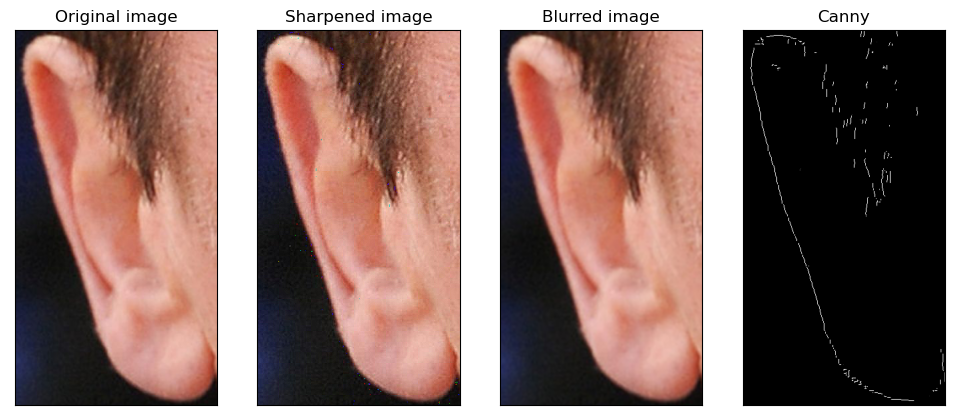

In [62]:
low_threshold = 25
high_threshold = 50
kernelForCanny = (1 / 18) * np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
filteri = Filters("./test_img.png", kernelForCanny, low_threshold, high_threshold)
filteri.showAll()